In [744]:
import torch
from torch import nn
from matplotlib import pyplot as plt

In [745]:
torch.__version__

'1.11.0'

In [746]:
device = "cuda" if torch.cuda.is_available() is True else "cpu"

In [747]:
device

'cuda'

# Linear Regression as an example

In [748]:
# Create groundtruth parameters
true_w = torch.tensor([[0.7]])
true_b = torch.tensor([[0.1]])

In [749]:
# Create data
X = torch.normal(mean=0, std=1, size=(100, 1))
y = torch.matmul(X, true_w) + true_b
noise = torch.normal(mean=0, std=0.1, size=y.shape)
y = y + noise
print(f"X:{X[:10]}")
print(f"Y:{y[:10]}")

X:tensor([[ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [ 1.7878],
        [-0.4780],
        [-0.3925],
        [-1.4036]])
Y:tensor([[ 0.6916],
        [-1.3211],
        [ 0.6780],
        [-0.8347],
        [ 0.1712],
        [-1.0563],
        [ 1.4032],
        [-0.1959],
        [-0.1027],
        [-0.8414]])


# Data Preparing and Preprocessing

**Data can be in almost any format:**

- Excel spreadsheet
- Images
- Videos
- Audios
- Texts
- DNA sequences

In [750]:
print(X[:10], X.shape)

tensor([[ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [ 1.7878],
        [-0.4780],
        [-0.3925],
        [-1.4036]]) torch.Size([100, 1])


## Data Visualisation

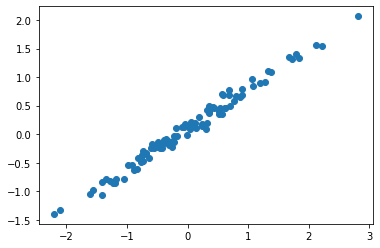

In [751]:
plt.scatter(X, y)

## Data Splitting
Split the whole dataset into:
- **training set (as course materials)**
- **validation set (as mock exams)**
- **test set (as exams)**

### Splitting data into training and test sets

In [752]:
train_slpit = int(0.8 * len(X))

X_train, y_train = X[:train_slpit], y[:train_slpit]
X_test, y_test = X[train_slpit:], y[train_slpit:]

In [753]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([80, 1])
torch.Size([80, 1])
torch.Size([20, 1])
torch.Size([20, 1])


## Data Visualisation

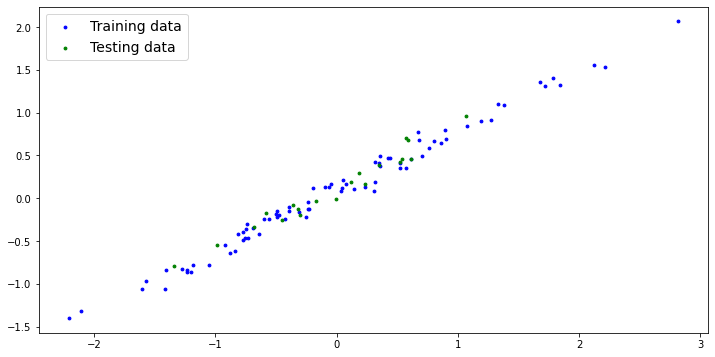

In [754]:
plt.figure(figsize=(12,6))
plt.scatter(X_train, y_train , c="b", s=8, label="Training data")
plt.scatter(X_test, y_test , c="g", s=8, label="Testing data")
plt.legend(prop={"size":14})

In [755]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Model Building

**Essentials**
- torch.nn: all of the buildings for computational graphs
- torch.nn.Parameter: parameters to be learned
- torch.nn.Module: the base class for all nn modules
- torch.optim: optimizers to deal with gradient descent
- def foward(): apply foward computation to input data
- torch.util.data.Dataset: a map between features and labels
- torch.util.data.DataLoader: a Python iterable over a torch Dataset

**Training**
- Loss functions: measure how the model's predictions are to the labels
- Optimizer: optimize the parameters to an ideal range

In [756]:
# # Create a linear regression model class
# class LinearRegressionModel(nn.Module): # almost everything in PyTorch inheirtes from PyTorch nn.module
#     def __init__(self):
#         super().__init__()
#         self.weights = nn.Parameter(torch.randn(1))
#         self.bias = nn.Parameter(torch.randn(1))
        
#     # Forward propagation
#     def forward(self, x):
#         return self.weights * x + self.bias
#         # return nn.Linear(1, 1, self.bias)

class LinearRegressionModel(nn.Module):
    def __init__(self, features_dim, labels_dim):
        super().__init__()
        self.linear_layer = nn.Linear(features_dim, labels_dim)
    def forward(self, x):
        return self.linear_layer(x)



## Check model contents

In [757]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model = LinearRegressionModel(1, 1)
model.to(device)
next(model.parameters()).to(device)
# Check out the parameters
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

## Making prediction before training

In [758]:
with torch.inference_mode(): # inference mode makes predicting faster
    y_preds = model(X_test)
y_preds

# Or using with torch.no_grad(), though torch.inference_mode() is preferred
# with torch.with_no_grad(): 
#     y_preds = model_0(X_test)
# y_preds

tensor([[-0.1952],
        [ 0.3823],
        [ 1.2400],
        [ 1.2310],
        [ 1.6462],
        [ 0.4858],
        [ 0.3110],
        [ 1.2691],
        [ 0.9736],
        [ 0.5565],
        [ 0.5881],
        [ 1.2803],
        [ 0.8290],
        [ 0.5978],
        [ 0.0758],
        [ 0.9243],
        [ 1.0975],
        [ 1.3019],
        [ 0.7005],
        [ 1.0084]], device='cuda:0')

In [759]:
y_preds.shape

torch.Size([20, 1])

In [760]:
# plt.figure(figsize=(12,6))
# # plt.scatter(X_train, y_train , c="b", s=8, label="Training data")
# plt.scatter(X_test, y_test , c="g", s=8, label="Testing data")
# plt.scatter(X_test, y_preds , c="r", s=8, label="Predictions")
# plt.legend(prop={"size":14})

# Training
1. Loop through theh data
2. Foward propagation
3. Compute the loss
4. Backward propagation - calculate the gradients of each of the parameters and update them

## Defining hyperparameters

In [761]:
epochs = 100
learning_rate = 0.1

## Defining loss function and optimizer

In [762]:
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam([var1, var2], lr=0.0001)

## Training process

In [763]:
# Recording the epoch counts, loss
epoch_list = []
train_loss_list = []
# Training
# 1. Loop through theh data
for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    
    # 2. Foward propagation
    y_preds = model(X_train)
    
    # 3. Compute the loss
    loss = criterion(y_preds, y_train) # predictions first
    # print(f"Training loss: {loss.item()}")
    # 4. Backward propagation
    optimizer.zero_grad() # If not, the gradients get accumulated
    loss.backward() # compute the gradients of parameters
    optimizer.step() # update the parameters
    epoch_list.append(epoch)
    train_loss_list.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Parameters: {list(model.parameters())}")

    # Set the model to evaluating mode and turn off gradient tracking
    # model.eval()

Epoch: 0, Loss: 0.5536317825317383, Parameters: [Parameter containing:
tensor([[0.7524]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.6827], device='cuda:0', requires_grad=True)]
Epoch: 10, Loss: 0.013421962037682533, Parameters: [Parameter containing:
tensor([[0.7077]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.1565], device='cuda:0', requires_grad=True)]
Epoch: 20, Loss: 0.007178314030170441, Parameters: [Parameter containing:
tensor([[0.7026]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.1000], device='cuda:0', requires_grad=True)]
Epoch: 30, Loss: 0.007106326520442963, Parameters: [Parameter containing:
tensor([[0.7020]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.0939], device='cuda:0', requires_grad=True)]
Epoch: 40, Loss: 0.007105558644980192, Parameters: [Parameter containing:
tensor([[0.7019]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.0933], d

Text(0.5, 1.0, 'Training loss curve')

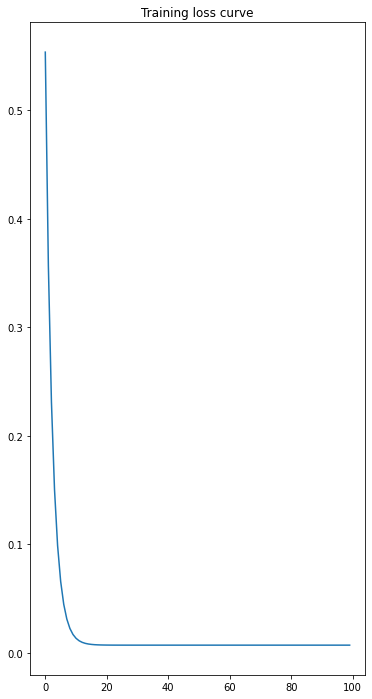

In [764]:
# Plot the loss curves
plt.figure(figsize=(6,12))
plt.plot(epoch_list, train_loss_list, label="Training Loss")
plt.title("Training loss curve")

## Check parameters after training

In [765]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7019]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.0932], device='cuda:0'))])

# Evaluating

In [766]:
# evaluating model on training set:
model.eval()

with torch.inference_mode():
    y_preds = model(X_train)

In [767]:
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()
y_preds= y_preds.cpu()

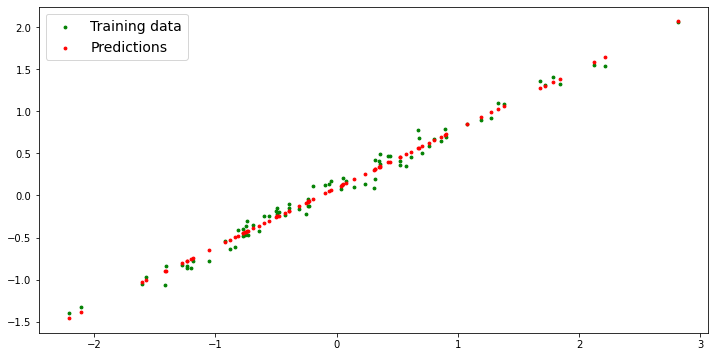

In [768]:
plt.figure(figsize=(12,6))
# plt.scatter(X_train, y_train , c="b", s=8, label="Training data")
plt.scatter(X_train, y_train , c="g", s=8, label="Training data")
plt.scatter(X_train, y_preds , c="r", s=8, label="Predictions")
plt.legend(prop={"size":14})

# Predicting

In [789]:
model.cpu()
next(model.parameters()).cpu()

Parameter containing:
tensor([[0.7019]], requires_grad=True)

In [790]:
with torch.inference_mode():
    preds = model(X_test)
test_loss = criterion(preds, X_test)
test_loss

tensor(0.0414)

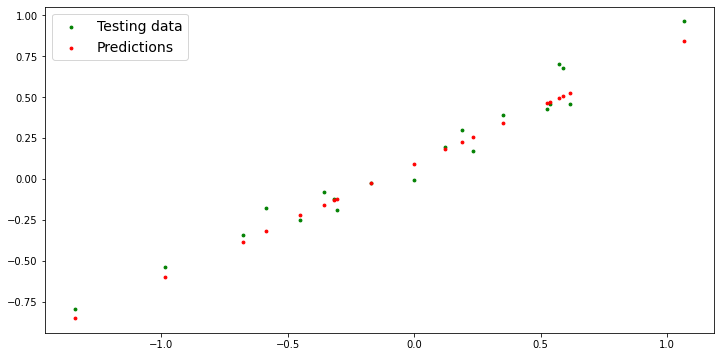

In [791]:
plt.figure(figsize=(12,6))

plt.scatter(X_test, y_test , c="g", s=8, label="Testing data")
plt.scatter(X_test, preds , c="r", s=8, label="Predictions")
plt.legend(prop={"size":14})

In [792]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7019]])),
             ('linear_layer.bias', tensor([0.0932]))])

In [793]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'params': [0, 1]}]}

# Saving and loading the model
1. `torch.save()`: save a PyTorch object in Python's pickle format
2. `torch.load()`: load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`: load a model's saved state dictionary

## Saving the model

In [794]:
import os

In [795]:
# Creating the save path
PATH = "./models"
os.mkdir(path="./models")
MODEL_NAME = "linear_regression_model.pth"


In [796]:
MODEL_SAVE_PATH = PATH+'/'+MODEL_NAME
MODEL_SAVE_PATH

'./models/linear_regression_model.pth'

In [797]:
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

## Loading the model

In [798]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7019]])),
             ('linear_layer.bias', tensor([0.0932]))])

In [800]:
# Instantiate a new instance of the model class
loaded_model = LinearRegressionModel(1,1)

# Load the saved model's state_dict into loaded_model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [801]:
loaded_model.state_dict()
# Loaded successfully

OrderedDict([('linear_layer.weight', tensor([[0.7019]])),
             ('linear_layer.bias', tensor([0.0932]))])

In [802]:
# Predicting with the loaded model
with torch.inference_mode():
    new_preds = loaded_model(X_test)
test_loss = criterion(new_preds, X_test)
new_preds, test_loss

(tensor([[-0.8478],
         [-0.3177],
         [ 0.4695],
         [ 0.4614],
         [ 0.8421],
         [-0.2228],
         [-0.3832],
         [ 0.4963],
         [ 0.2250],
         [-0.1578],
         [-0.1290],
         [ 0.5064],
         [ 0.0923],
         [-0.1199],
         [-0.5992],
         [ 0.1797],
         [ 0.3388],
         [ 0.5265],
         [-0.0257],
         [ 0.2569]]),
 tensor(0.0414))

In [803]:
new_preds == preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])